In [1]:
import sys
import os
#import torch
import zarr
import lilio
import warnings
import xarray as xr
import numpy as np
import pandas as pd
import pyarrow as pa
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs

#from torch import nn
from pathlib import Path
from scipy.stats import linregress, spearmanr
from typing import Union
from sklearn.model_selection import cross_val_predict
from matplotlib.gridspec import GridSpec

sys.path.append(os.path.expanduser('~/Documents/Medley'))
from Medley.dataloading import get_monthly_data, prep_ecad, datapath, prep_and_resample
from Medley.utils import data_for_pcolormesh, udomains, regions, tscolnames
from Medley.analysis import trendfit_robust
from Medley.preprocessing import Anomalizer, simultaneous_resample, makemask, average_within_mask, single_target_lagged_resample, multi_target_lagged_resample,remove_bottleneck
from Medley.crossval import SpatiotemporalSplit
from Medley.estimators import return_estimator
from Medley.visualization import plot_stations, plot_plus_stations

In [2]:
warnings.simplefilter('ignore',category=RuntimeWarning)
warnings.simplefilter('ignore',category=UserWarning)

## Timeseries
Length, data source, literature, directionality

In [3]:
preds = get_monthly_data()
# Red is drying, blue is wettening, grey = unknown.
directionality = pd.Series(['blue','blue','blue','blue', #enso 12, 3,34,4
                            'grey','grey', # amo
                            'blue', # amoc
                            'red','red', # nao
                            'red', # snao
                            'red','red', # ao
                            'blue', # east atl
                            'grey', # pdo
                            'red', # gmst
                            'red','blue', # mjo3, mjo6
                            'grey', # qbo
                            'red','red','grey','blue','grey','grey', # med250 latmax, 20,30,40,50,60 
                            'grey','grey','grey','grey','grey','grey', # atl250 latmax, 20,30,40,50,60 
                            'grey','red','blue','grey','grey','red', # med500 latmax, 20,30,40,50,60 
                            'red','blue','grey','grey','red','red', # atl500 latmax, 20,30,40,50,60 
                            'red', # vortex
                            'grey','grey','grey','grey','grey','grey', # atleke latmax, 20,30,40,50,60 
                            'grey','red','red', # iod, west ind, east ind.
                           ],index = preds.columns)

In [4]:
valid = ~preds.isnull()
for i, col in enumerate(valid.columns):
    valid.loc[:,col] = np.where(valid.loc[:,col], i, np.nan)


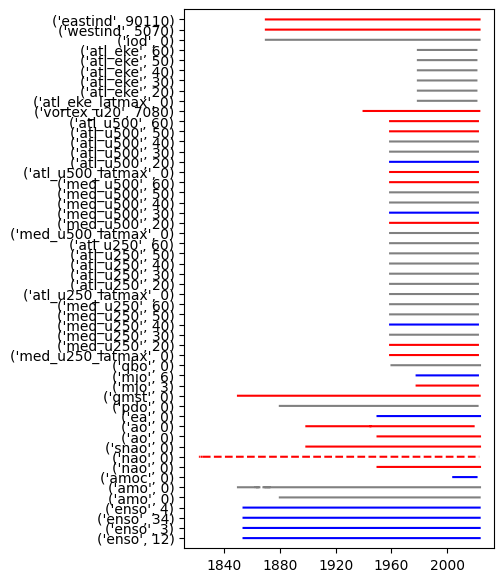

In [5]:
fig, ax = plt.subplots(figsize = (4,7))
for col in valid.columns:
    if 'station' in col:
        sty = 'dashed'
    else:
        sty = 'solid'
    ax.plot(valid.index, valid.loc[:,col], ls = sty, color = directionality.loc[col])
#valid.plot(color = 'grey', ax = ax, legend = False)
ax.set_ylim(-1,len(valid.columns))
ax.set_yticks(np.arange(0,len(valid.columns)))
ax.set_yticklabels(valid.columns.droplevel(-1).to_flat_index())
plt.show()

## Regions, local trend and aggregated timeseries.

In [6]:
spi_ecad = pd.read_hdf('/scistor/ivm/jsn295/Medi/monthly/eca_preaggregated_SPI3.h5')
spi_ecad.index.name = 'time'
spi_ecad_locs = pd.read_hdf('/scistor/ivm/jsn295/Medi/monthly/eca_preaggregated_SPI3_stations.h5')

In [19]:
min_count = 60 # So basically 60/3months = 20 seasons.
spi_ecad_1950 = spi_ecad.loc[slice('1950',None),:].stack().to_xarray()
# temporal subsetting to jfm
timeset = spi_ecad_1950.get_index('time').month.map(lambda m: m in list(range(4)))
spi_ecad_1950 = spi_ecad_1950.sel(time = timeset)
spi_ecad_1950.attrs['units'] = 'std'
#spi_ecad_1950.groupby(spi_ecad_1950.time.dt.year).mean()
spi_trend = trendfit_robust(spi_ecad_1950, standardize=False, min_count = min_count).sel(what = 'slope')
spi_trend = spi_trend * 10 # To std/decade
spi_trend = spi_trend.to_pandas().dropna()
#spi_trend = spi_trend.loc[spi_trend.abs().sort_values().index] # Sorting by absolute values
spi_trend = spi_trend.sort_values(ascending = False)

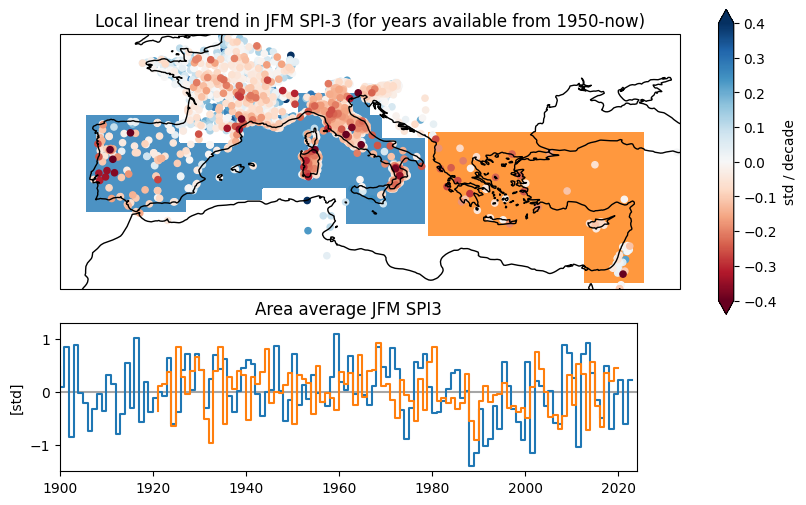

In [20]:
fig = plt.figure(figsize=(10,6),facecolor='white')

gs = GridSpec(nrows = 9, ncols=8, wspace=0.2, hspace = 0.2)
ax1 = fig.add_subplot(gs[:6,:], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[6:,:6])

shading = 'nearest'
for i, regionname in enumerate(['medwest','medeast']):
    _, y_agg, _ = prep_and_resample(target_region = regions[regionname], target_var='SPI3', minsamples = 10, 
                                    resampling = 'single', resampling_kwargs = dict(firstmonth = 1, lastmonth = 3))
    y_agg = y_agg.dropna()
    ax2.step(y_agg.index, y_agg)
    mask = makemask(regions[regionname])
    dat = xr.where(mask, mask, np.nan)
    lat, lon, dat = data_for_pcolormesh(dat, shading = shading)
    ax1.contourf(lat, lon, dat, transform = ccrs.PlateCarree(), colors = list(mcolors.TABLEAU_COLORS.keys())[i], 
               alpha = 0.8)

fig, ax1, im = plot_stations(stat = spi_trend,
                            statloc=spi_ecad_locs, fig = fig, ax = ax1, 
                            cbar= True, 
                            scatter_kwargs={'s':20,#'edgecolors':'black','linewidths':0.1,
                                            'vmin': -0.4, 'vmax' : 0.4, 'cmap':'RdBu'},
                           cbar_kwargs = dict(extend = 'both', label = 'std / decade'))
ax1.set_extent((-12,40,29.5,48))
ax1.coastlines()
ax1.set_title('Local linear trend in JFM SPI-3 (for years available from 1950-now)')
ax2.set_title('Area average JFM SPI3')
ax2.set_ylabel('[std]')
ax2.set_xlim((1900,2024))
ax2.set_ylim(-1.5,1.3)
ax2.hlines(0,1900,2024, color = 'grey', alpha = 0.7, zorder = 0)
plt.show()

Picture for France and Corsica changes quite a bit if dryest trends are placed on top.

## Seasonality in target variable trends, and in its relation to predictors

In [3]:
# potential anomalization has no effect on rank correlation, because conducted per month.
preds = get_monthly_data()

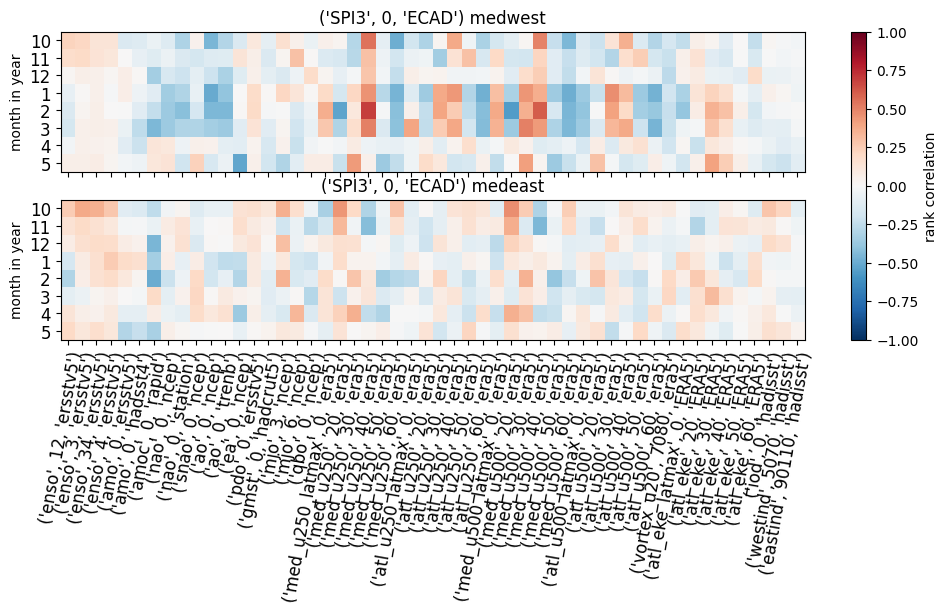

In [5]:
fig, axes = plt.subplots(figsize = (12,4), nrows = 2, sharex = True)
for i, regionname in enumerate(['medwest','medeast']):
    # cannot use prep-and resample, because that is always lagged.
    target = prep_ecad(target_region=regions[regionname], target_var = 'SPI3').to_frame()
    target.columns = pd.MultiIndex.from_tuples([('SPI3',0,'ECAD')], names = tscolnames)
    Xres, yres, _ = simultaneous_resample(X = preds, y = target, firstmonth = 1, lastmonth = 1, average = False)
    # Plotting correlations per month, single months
    months = [10,11,12,1,2,3,4,5]
    othervars = Xres.columns
    corrcoefs = xr.DataArray(np.full((len(months),len(othervars)),np.nan), dims = ('month','variables'),
                            coords = {'month':months, 'variables':othervars}, name = 'spearmanr')
    for month in months:
        Xres, yres, _ = simultaneous_resample(X = preds, y = target, firstmonth = month, lastmonth = month, average = False)
        for var in othervars:
            dat = Xres.loc[:,[var]].join(yres, how = 'inner').dropna(how = 'any')
            corrcoefs.loc[month,var] = spearmanr(dat)[0]
    ax = axes[i]
    im = ax.imshow(corrcoefs.values, vmin = -1, vmax = 1, cmap = 'RdBu_r', aspect = 'auto')
    ax.set_title(f'{target.columns[0]} {regionname}')
    ax.set_yticks(np.arange(corrcoefs.shape[0]))
    ax.set_yticklabels(corrcoefs.indexes['month'].values, size = 12)
    ax.set_ylabel('month in year')
ax.set_xticks(np.arange(corrcoefs.shape[1]))
ax.set_xticklabels(corrcoefs.indexes['variables'].to_flat_index().values, size = 12)
plt.setp(ax.get_xticklabels(), rotation=80, ha="right",
         rotation_mode="anchor")
fig.colorbar(im, ax = axes, label = 'rank correlation')
plt.show()